In [3]:
import pandas as pd
import numpy as np

import urllib
import mechanize
from bs4 import BeautifulSoup

import geocoder

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


import requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt



# To handle Toronto auto-theft data

In [4]:
df_toronto_raw=pd.read_csv("https://opendata.arcgis.com/datasets/0b4f2f648df54adeb03aef5484396585_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")
df_toronto_raw.head()

X          Y  Index_ event_unique_id            occurrencedate  \
0 -79.188606  43.763969  166869  GO-20171835920  2017-10-10T11:00:00.000Z   
1 -79.545822  43.589569  166870   GO-2018342956  2018-02-22T22:00:00.000Z   
2 -79.313820  43.675320  166871   GO-2018339431  2018-02-20T15:30:00.000Z   
3 -79.439255  43.758656  166872   GO-2018344652  2018-02-19T09:00:00.000Z   
4 -79.440674  43.727829  166873   GO-2018344792  2018-02-19T20:00:00.000Z   

               reporteddate premisetype  ucr_code  ucr_ext  \
0  2017-10-10T12:39:00.000Z     Outside      2135      210   
1  2018-02-23T11:48:00.000Z     Outside      2135      210   
2  2018-02-22T20:51:00.000Z     Outside      2135      210   
3  2018-02-23T16:16:00.000Z     Outside      2135      210   
4  2018-02-23T17:06:00.000Z   Apartment      2135      210   

                  offence  ...  occurrencedayofyear occurrencedayofweek  \
0  Theft Of Motor Vehicle  ...                283.0          Tuesday      
1  Theft Of Motor Vehicle  ...                 53.0          Thursday     
2  Theft Of Motor Vehicle  ...                 51.0          Tuesday      
3  Theft Of Motor Vehicle  ...                 50.0          Monday       
4  Theft Of Motor Vehicle  ...                 50.0          Monday       

   occurrencehour         MCI Division  Hood_ID             Neighbourhood  \
0              11  Auto Theft      D43      136           West Hill (136)   
1              22  Auto Theft      D22       19          Long Branch (19)   
2              15  Auto Theft      D55       64    Woodbine Corridor (64)   
3               9  Auto Theft      D32       34       Bathurst Manor (34)   
4              20  Auto Theft      D32       32  Englemount-Lawrence (32)   

         Lat       Long  ObjectId  
0  43.763969 -79.188606      4001  
1  43.589569 -79.545822      4002  
2  43.675320 -79.313820      4003  
3  43.758655 -79.439255      4004  
4  43.727829 -79.440674      4005  

[5 rows x 29 columns]

In [5]:
t_columns=["occurrencedate","premisetype","occurrencedayofweek","occurrencehour","Neighbourhood","Lat","Long"]
df_toronto = df_toronto_raw[t_columns]

In [6]:
df_toronto.head()

occurrencedate premisetype occurrencedayofweek  occurrencehour  \
0  2017-10-10T11:00:00.000Z     Outside          Tuesday                 11   
1  2018-02-22T22:00:00.000Z     Outside          Thursday                22   
2  2018-02-20T15:30:00.000Z     Outside          Tuesday                 15   
3  2018-02-19T09:00:00.000Z     Outside          Monday                   9   
4  2018-02-19T20:00:00.000Z   Apartment          Monday                  20   

              Neighbourhood        Lat       Long  
0           West Hill (136)  43.763969 -79.188606  
1          Long Branch (19)  43.589569 -79.545822  
2    Woodbine Corridor (64)  43.675320 -79.313820  
3       Bathurst Manor (34)  43.758655 -79.439255  
4  Englemount-Lawrence (32)  43.727829 -79.440674

In [7]:
df_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18178 entries, 0 to 18177
Data columns (total 7 columns):
occurrencedate         18178 non-null object
premisetype            18178 non-null object
occurrencedayofweek    18175 non-null object
occurrencehour         18178 non-null int64
Neighbourhood          18178 non-null object
Lat                    18178 non-null float64
Long                   18178 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 994.2+ KB


In [8]:
#keep only 2017 and 2018 data
df_toronto_1718=df_toronto[df_toronto["occurrencedate"].str.contains("2018-*",regex=True) | df_toronto["occurrencedate"].str.contains("2017-*",regex=True)]

In [9]:
#extract month
df_toronto_1718["occurrancemonth"]=df_toronto_1718["occurrencedate"].str[5:7]

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
df_toronto_1718.head()

occurrencedate premisetype occurrencedayofweek  occurrencehour  \
0  2017-10-10T11:00:00.000Z     Outside          Tuesday                 11   
1  2018-02-22T22:00:00.000Z     Outside          Thursday                22   
2  2018-02-20T15:30:00.000Z     Outside          Tuesday                 15   
3  2018-02-19T09:00:00.000Z     Outside          Monday                   9   
4  2018-02-19T20:00:00.000Z   Apartment          Monday                  20   

              Neighbourhood        Lat       Long occurrancemonth  
0           West Hill (136)  43.763969 -79.188606              10  
1          Long Branch (19)  43.589569 -79.545822              02  
2    Woodbine Corridor (64)  43.675320 -79.313820              02  
3       Bathurst Manor (34)  43.758655 -79.439255              02  
4  Englemount-Lawrence (32)  43.727829 -79.440674              02

In [11]:
df_toronto_1718[["occurrencedayofweek","occurrencehour"]].groupby(['occurrencedayofweek']).count()

occurrencehour
occurrencedayofweek                
Friday                         1239
Monday                         1189
Saturday                       1148
Sunday                         1085
Thursday                       1192
Tuesday                        1158
Wednesday                      1164

Text(0, 0.5, '')

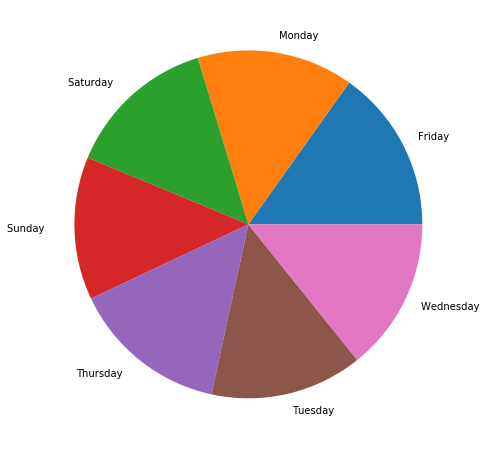

In [193]:
df_toronto_1718[["occurrencedayofweek","occurrencehour"]].groupby(['occurrencedayofweek']).count().plot(kind="pie",subplots=True,legend=False,figsize=(8,8))
#ax.set_ylabel('')
#ax.show()
plt.ylabel('')

In [202]:
df_toronto_1718.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8175 entries, 0 to 18177
Data columns (total 9 columns):
occurrencedate         8175 non-null object
premisetype            8175 non-null object
occurrencedayofweek    8175 non-null object
occurrencehour         8175 non-null int64
Neighbourhood          8175 non-null object
Lat                    8175 non-null float64
Long                   8175 non-null float64
occurrancemonth        8175 non-null object
date                   8175 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 638.7+ KB


Text(0, 0.5, '')

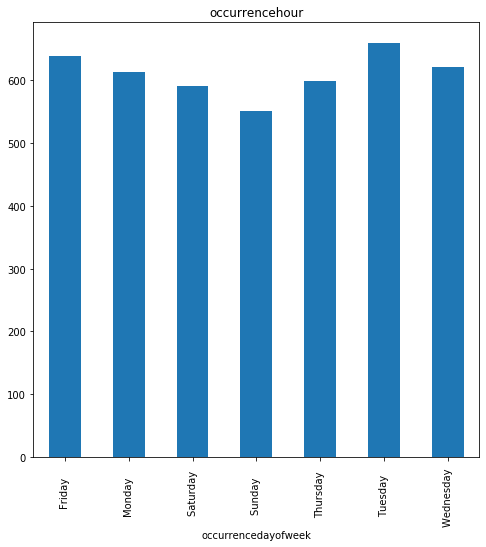

In [206]:
#df_toronto_1718[["occurrencedayofweek","occurrencehour"]].groupby(['occurrencedayofweek']).count().plot(kind="pie",subplots=True,legend=False,figsize=(8,8))
#ax.set_ylabel('')
#ax.show()
#plt.ylabel('')
summer_months=["05","06","07","08","09","10"]
#df_toronto_1718[df_toronto_1718["occurrancemonth"].isin(summer_months)]


df_toronto_1718[df_toronto_1718["occurrancemonth"].isin(summer_months)][["occurrencedayofweek","occurrencehour"]].groupby(['occurrencedayofweek']).count().plot(kind="bar",subplots=True,legend=False,figsize=(8,8))


#df_toronto_1718[df_toronto_1718["occurrancemonth"].isin(summer_months)][["occurrencedayofweek","occurrencehour"]].groupby(['occurrencedayofweek']).count().plot(kind="pie",subplots=True,legend=False,figsize=(8,8))
#ax.set_ylabel('')
#ax.show()
plt.ylabel('')

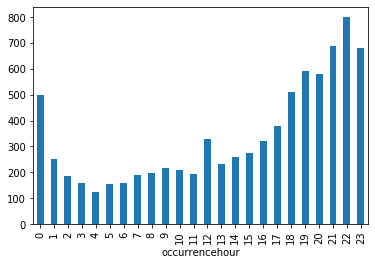

In [52]:
df_toronto_1718[["occurrencedayofweek","occurrencehour"]].groupby(['occurrencehour']).count().plot(kind="bar",legend=False)
plt.show()

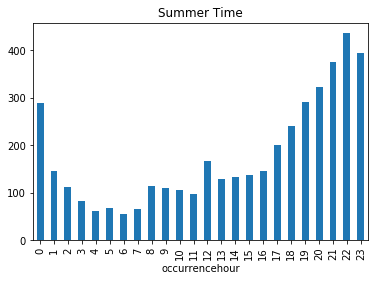

In [208]:

df_toronto_1718[df_toronto_1718["occurrancemonth"].isin(summer_months)][["occurrencedayofweek","occurrencehour"]].groupby(['occurrencehour']).count().plot(kind="bar",legend=False,title="Summer Time")
plt.show()

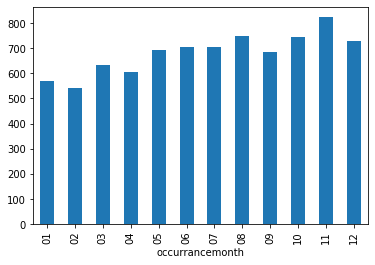

In [14]:
df_toronto_1718[["occurrencedayofweek","occurrancemonth"]].groupby(['occurrancemonth']).count().plot(kind="bar",legend=False)
plt.show()

In [15]:
df_toronto_1718.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8175 entries, 0 to 18177
Data columns (total 8 columns):
occurrencedate         8175 non-null object
premisetype            8175 non-null object
occurrencedayofweek    8175 non-null object
occurrencehour         8175 non-null int64
Neighbourhood          8175 non-null object
Lat                    8175 non-null float64
Long                   8175 non-null float64
occurrancemonth        8175 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 574.8+ KB


In [210]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [211]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(df_toronto_1718['Lat'], df_toronto_1718['Long']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        #popup=label,
        #color=rainbow[cluster-1],
        fill=False,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.2).add_to(map_clusters)
       
display(map_clusters)

In [156]:
# to add temperature info
df_temp_17=pd.read_csv("en_climate_daily_ON_6158355_2017_P1D.csv")
df_temp_17.fillna(method="ffill",inplace=True)

In [157]:
df_temp_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 31 columns):
Longitude (x)                365 non-null float64
Latitude (y)                 365 non-null float64
Station Name                 365 non-null object
Climate ID                   365 non-null int64
Date/Time                    365 non-null object
Year                         365 non-null int64
Month                        365 non-null int64
Day                          365 non-null int64
Data Quality                 0 non-null float64
Max Temp (°C)                365 non-null float64
Max Temp Flag                301 non-null object
Min Temp (°C)                365 non-null float64
Min Temp Flag                301 non-null object
Mean Temp (°C)               365 non-null float64
Mean Temp Flag               301 non-null object
Heat Deg Days (°C)           365 non-null float64
Heat Deg Days Flag           301 non-null object
Cool Deg Days (°C)           365 non-null float64
Cool Deg Da

In [158]:
df_temp_plot=df_temp_17[["Date/Time","Mean Temp (°C)","Total Precip (mm)"]]


In [159]:
df_temp_plot.set_index("Date/Time")

Mean Temp (°C)  Total Precip (mm)
Date/Time                                    
2017-01-01             1.3                0.0
2017-01-02             3.1                0.0
2017-01-03             3.6               11.3
2017-01-04            -1.9                0.6
2017-01-05            -7.8                0.0
2017-01-06            -8.9                0.0
2017-01-07            -9.1                0.0
2017-01-08            -9.7                0.0
2017-01-09            -4.9                0.0
2017-01-10             2.7               18.3
2017-01-11             5.1                4.3
2017-01-12             4.4               15.6
2017-01-13            -4.2                0.0
2017-01-14            -5.3                0.0
2017-01-15            -2.0                0.0
2017-01-16            -0.2                0.0
2017-01-17             1.9               13.5
2017-01-18             3.2                0.4
2017-01-19             3.1                0.0
2017-01-20             3.1                0.0
2017-01-21             5.1                0.0
2017-01-22             4.2                0.0
2017-01-23             2.8                0.0
2017-01-24             1.1                0.5
2017-01-25             3.4                2.6
2017-01-26             3.2                2.2
2017-01-27             0.9                0.3
2017-01-28            -0.9                0.7
2017-01-29            -3.5                0.0
2017-01-30            -7.1                0.0
...                    ...                ...
2017-12-02             5.1                0.0
2017-12-03             4.9                0.0
2017-12-04             6.9                2.4
2017-12-05             5.7                5.6
2017-12-06             1.1                0.0
2017-12-07            -0.6                0.0
2017-12-08            -0.8                0.0
2017-12-09             0.1                0.0
2017-12-10            -2.0                0.0
2017-12-11            -4.1                3.1
2017-12-12            -6.4                3.7
2017-12-13            -9.9                0.2
2017-12-14            -9.9                0.2
2017-12-15            -6.4                0.5
2017-12-16            -5.7                0.0
2017-12-17            -8.4                0.2
2017-12-18            -0.6                2.6
2017-12-19             5.2                0.0
2017-12-20             0.1                0.0
2017-12-21            -3.3                2.7
2017-12-22            -3.8                3.4
2017-12-23            -2.1                3.1
2017-12-24            -3.0                7.2
2017-12-25            -6.8                1.0
2017-12-26           -12.3                0.0
2017-12-27           -13.9                0.0
2017-12-28           -15.7                0.2
2017-12-29           -10.8                1.0
2017-12-30           -12.5                0.2
2017-12-31           -17.0                0.0

[365 rows x 2 columns]

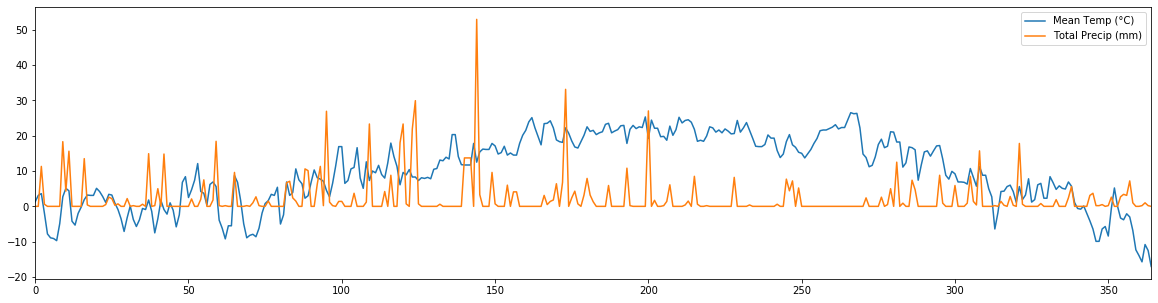

In [160]:
df_temp_plot.sort_values("Date/Time").plot(kind='line',figsize=(20,5))

In [148]:
#df_toronto_17=df_toronto_1718
df_toronto_1718["date"]=df_toronto_1718["occurrencedate"].str[0:10]

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [162]:
#df_temp_plot.merge(df_toronto_1718,left_on="Date/Time",right_on="date")
df_tor_17=df_toronto_1718[df_toronto_1718["date"].str.contains("2017-")].sort_values("date")[["date","Lat"]].groupby(["date"]).count()

#df_tor_17

df_tor_17=df_temp_plot.merge(df_tor_17,left_on="Date/Time",right_on="date")

df_tor_17


Date/Time  Mean Temp (°C)  Total Precip (mm)  Lat
0    2017-01-01             1.3                0.0    9
1    2017-01-02             3.1                0.0    6
2    2017-01-03             3.6               11.3   10
3    2017-01-04            -1.9                0.6    7
4    2017-01-05            -7.8                0.0    5
5    2017-01-06            -8.9                0.0    7
6    2017-01-07            -9.1                0.0    8
7    2017-01-08            -9.7                0.0    4
8    2017-01-09            -4.9                0.0    8
9    2017-01-10             2.7               18.3    9
10   2017-01-11             5.1                4.3    9
11   2017-01-12             4.4               15.6   12
12   2017-01-13            -4.2                0.0   10
13   2017-01-14            -5.3                0.0    9
14   2017-01-15            -2.0                0.0    7
15   2017-01-16            -0.2                0.0    9
16   2017-01-17             1.9               13.5    8
17   2017-01-18             3.2                0.4    8
18   2017-01-19             3.1                0.0    7
19   2017-01-20             3.1                0.0    6
20   2017-01-21             5.1                0.0    8
21   2017-01-22             4.2                0.0   11
22   2017-01-23             2.8                0.0    8
23   2017-01-24             1.1                0.5    5
24   2017-01-25             3.4                2.6    6
25   2017-01-26             3.2                2.2    9
26   2017-01-27             0.9                0.3    4
27   2017-01-28            -0.9                0.7   10
28   2017-01-29            -3.5                0.0    8
29   2017-01-30            -7.1                0.0    8
..          ...             ...                ...  ...
335  2017-12-02             5.1                0.0    7
336  2017-12-03             4.9                0.0   12
337  2017-12-04             6.9                2.4    8
338  2017-12-05             5.7                5.6   12
339  2017-12-06             1.1                0.0    7
340  2017-12-07            -0.6                0.0    9
341  2017-12-08            -0.8                0.0   19
342  2017-12-09             0.1                0.0   14
343  2017-12-10            -2.0                0.0   10
344  2017-12-11            -4.1                3.1   11
345  2017-12-12            -6.4                3.7    9
346  2017-12-13            -9.9                0.2    8
347  2017-12-14            -9.9                0.2   10
348  2017-12-15            -6.4                0.5    8
349  2017-12-16            -5.7                0.0   12
350  2017-12-17            -8.4                0.2   11
351  2017-12-18            -0.6                2.6   17
352  2017-12-19             5.2                0.0    8
353  2017-12-20             0.1                0.0   15
354  2017-12-21            -3.3                2.7   13
355  2017-12-22            -3.8                3.4   10
356  2017-12-23            -2.1                3.1    6
357  2017-12-24            -3.0                7.2   11
358  2017-12-25            -6.8                1.0    3
359  2017-12-26           -12.3                0.0    8
360  2017-12-27           -13.9                0.0    6
361  2017-12-28           -15.7                0.2   10
362  2017-12-29           -10.8                1.0    5
363  2017-12-30           -12.5                0.2   11
364  2017-12-31           -17.0                0.0   14

[365 rows x 4 columns]

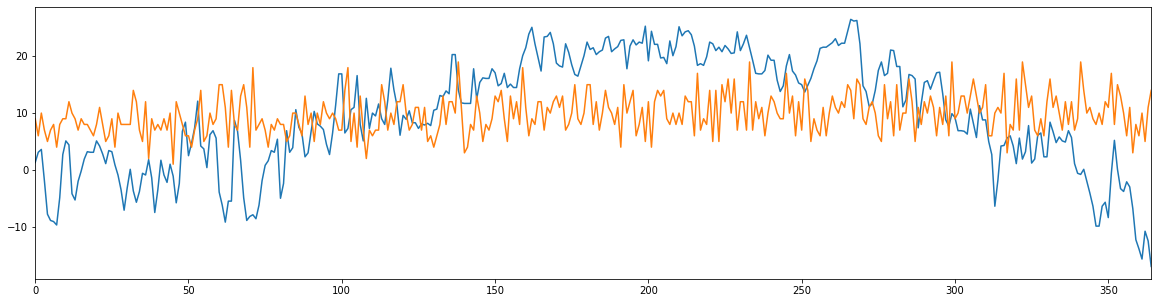

In [163]:

df_tor_17[["Date/Time","Mean Temp (°C)","Lat"]].plot(kind="line",legend=False,figsize=(20,5))

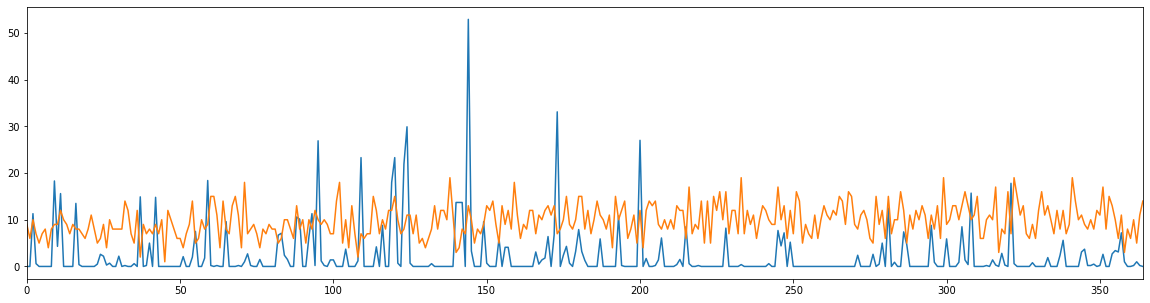

In [164]:

df_tor_17[["Date/Time","Total Precip (mm)","Lat"]].plot(kind="line",legend=False,figsize=(20,5))

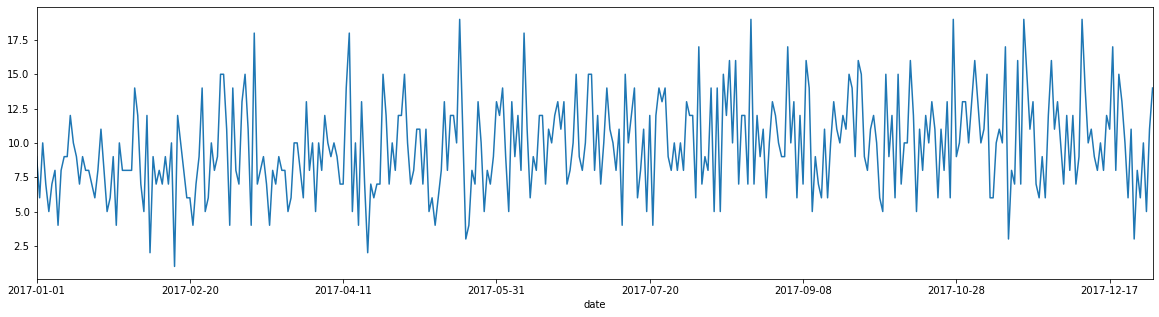

<Figure size 720x360 with 0 Axes>

In [87]:

df_toronto_1718[df_toronto_1718["date"].str.contains("2017-")].sort_values("date")[["date","Lat"]].groupby(["date"]).count().plot(kind="line",legend=False,figsize=(20,5))
plt.figure(figsize=(10,5))
plt.show()

# To handle Vancouver data

In [18]:
df_van_raw = pd.read_csv("crimedata_csv_all_years.csv")

In [19]:
df_van_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624038 entries, 0 to 624037
Data columns (total 10 columns):
TYPE             624038 non-null object
YEAR             624038 non-null int64
MONTH            624038 non-null int64
DAY              624038 non-null int64
HOUR             624038 non-null int64
MINUTE           624038 non-null int64
HUNDRED_BLOCK    624025 non-null object
NEIGHBOURHOOD    559076 non-null object
X                623918 non-null float64
Y                623918 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 47.6+ MB


In [20]:
df_van_raw.head()

TYPE  YEAR  MONTH  DAY  HOUR  MINUTE  \
0  Break and Enter Commercial  2012     12   14     8      52   
1  Break and Enter Commercial  2019      3    7     2       6   
2  Break and Enter Commercial  2019      8   27     4      12   
3  Break and Enter Commercial  2014      8    8     5      13   
4  Break and Enter Commercial  2005     11   14     3       9   

     HUNDRED_BLOCK NEIGHBOURHOOD              X             Y  
0              NaN      Oakridge  491285.000000  5.453433e+06  
1    10XX SITKA SQ      Fairview  490612.964805  5.457110e+06  
2  10XX ALBERNI ST      West End  491007.779775  5.459174e+06  
3  10XX ALBERNI ST      West End  491015.943352  5.459166e+06  
4  10XX ALBERNI ST      West End  491021.385727  5.459161e+06

In [21]:
df_van_raw.TYPE.unique()

array(['Break and Enter Commercial', 'Break and Enter Residential/Other',
       'Homicide', 'Mischief', 'Offence Against a Person', 'Other Theft',
       'Theft from Vehicle', 'Theft of Bicycle', 'Theft of Vehicle',
       'Vehicle Collision or Pedestrian Struck (with Fatality)',
       'Vehicle Collision or Pedestrian Struck (with Injury)'],
      dtype=object)

In [22]:
df_van = df_van_raw[df_van_raw["TYPE"].str.contains("Theft of Vehicle")]

In [23]:
year=[2017,2018]
df_van=df_van[df_van.YEAR.isin(year)]

df_van.reset_index(inplace=True)

In [24]:
df_van

index              TYPE  YEAR  MONTH  DAY  HOUR  MINUTE  \
0     556927  Theft of Vehicle  2017      2    2    17       0   
1     556948  Theft of Vehicle  2017      6   26    16      30   
2     556960  Theft of Vehicle  2018      8   30    12       5   
3     556980  Theft of Vehicle  2018      4   20     6      30   
4     556994  Theft of Vehicle  2018      4   27    17       0   
5     556996  Theft of Vehicle  2017      4   26    14       0   
6     557069  Theft of Vehicle  2017      6    5    20       0   
7     557071  Theft of Vehicle  2017      8    5     7      10   
8     557072  Theft of Vehicle  2017     10   22    19       0   
9     557073  Theft of Vehicle  2017     11    9    16       0   
10    557074  Theft of Vehicle  2017     12    5    15       0   
11    557075  Theft of Vehicle  2018      2    9     7       0   
12    557076  Theft of Vehicle  2018      2   25     6       0   
13    557077  Theft of Vehicle  2018      4    9     7      15   
14    557078  Theft of Vehicle  2018      5    5    17      40   
15    557079  Theft of Vehicle  2018     12   17    16       0   
16    557129  Theft of Vehicle  2017      5    6    23      30   
17    557130  Theft of Vehicle  2018      4   27    21      40   
18    557131  Theft of Vehicle  2017      6   15     9       0   
19    557141  Theft of Vehicle  2018      7   14    21       9   
20    557146  Theft of Vehicle  2018     12   23    14       0   
21    557155  Theft of Vehicle  2017      7   29    10      30   
22    557159  Theft of Vehicle  2017     12    1    17       0   
23    557168  Theft of Vehicle  2017     10   28    10      20   
24    557205  Theft of Vehicle  2017      9   18     7       0   
25    557246  Theft of Vehicle  2017      6    4    14       0   
26    557250  Theft of Vehicle  2017      3    5     8      34   
27    557255  Theft of Vehicle  2018      3   12     9       0   
28    557301  Theft of Vehicle  2017      7   14    20       0   
29    557318  Theft of Vehicle  2018      9   19     9       4   
...      ...               ...   ...    ...  ...   ...     ...   
2616  598161  Theft of Vehicle  2018      8   21    23       0   
2617  598176  Theft of Vehicle  2017      9    6    23       0   
2618  598188  Theft of Vehicle  2017     11   19     0      50   
2619  598191  Theft of Vehicle  2017      6    1    23       0   
2620  598194  Theft of Vehicle  2017      1    2    21       0   
2621  598195  Theft of Vehicle  2017      1   21     1      58   
2622  598196  Theft of Vehicle  2017      7   13    11      45   
2623  598197  Theft of Vehicle  2017     11   24    20       0   
2624  598215  Theft of Vehicle  2017      9   18    15       0   
2625  598216  Theft of Vehicle  2017      6   23    12       0   
2626  598218  Theft of Vehicle  2017      6   24    13      30   
2627  598225  Theft of Vehicle  2017      1    6    20       0   
2628  598227  Theft of Vehicle  2017      6    7    23      30   
2629  598243  Theft of Vehicle  2017      8    7    15      55   
2630  598257  Theft of Vehicle  2018      8   31    15      30   
2631  598261  Theft of Vehicle  2017      2   14     7      27   
2632  598269  Theft of Vehicle  2018     11   11    18       0   
2633  598294  Theft of Vehicle  2018      8   30    21      30   
2634  598308  Theft of Vehicle  2017      9   14     0       0   
2635  598309  Theft of Vehicle  2017      2   13    15       0   
2636  598319  Theft of Vehicle  2018      6   11    21       0   
2637  598333  Theft of Vehicle  2017      7   17    11      45   
2638  598347  Theft of Vehicle  2017      7    2    20       0   
2639  598434  Theft of Vehicle  2017      5   10     0       0   
2640  598435  Theft of Vehicle  2017      6    2    18      30   
2641  598436  Theft of Vehicle  2017      6   26     9       0   
2642  598437  Theft of Vehicle  2017     11   27    17      41   
2643  598438  Theft of Vehicle  2018     10    6     1       0   
2644  598439  Theft of Vehicle  2018     10   1

In [25]:
#function to convert UTM into Latitude and Longitude
import math

def utmToLatLng(zone, easting, northing, northernHemisphere=True):
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi

    if not northernHemisphere:
        latitude = -latitude

    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3

    return latitude, longitude

In [26]:
utmToLatLng(10,491058.81689,5.459123e+06)

(49.28479368673817, -123.12294580797483)

In [27]:
v_lat,v_log=[],[]
for idx,row in df_van.iterrows():
    lat,log=utmToLatLng(10,row.X,row.Y)
    v_lat.append(lat)
    v_log.append(log)

#df_van["latitude","longitude"]=pd.DataFrame({"latitude":v_lat,"longitude":v_log})
df_van["latitude"]=pd.Series(v_lat)
#df_van["longitude"]=pd.DataFrame({"longitude":v_lat})
df_log=pd.DataFrame({"longitude":v_log})
df_van["longitude"]=df_log["longitude"]

In [28]:
#df_van["lat","lon"]=df_van.apply(lambda x: utmToLatLng(10,x.X,x.Y),axis=1)

In [29]:
df_van.shape

(2646, 13)

In [30]:
df_van

index              TYPE  YEAR  MONTH  DAY  HOUR  MINUTE  \
0     556927  Theft of Vehicle  2017      2    2    17       0   
1     556948  Theft of Vehicle  2017      6   26    16      30   
2     556960  Theft of Vehicle  2018      8   30    12       5   
3     556980  Theft of Vehicle  2018      4   20     6      30   
4     556994  Theft of Vehicle  2018      4   27    17       0   
5     556996  Theft of Vehicle  2017      4   26    14       0   
6     557069  Theft of Vehicle  2017      6    5    20       0   
7     557071  Theft of Vehicle  2017      8    5     7      10   
8     557072  Theft of Vehicle  2017     10   22    19       0   
9     557073  Theft of Vehicle  2017     11    9    16       0   
10    557074  Theft of Vehicle  2017     12    5    15       0   
11    557075  Theft of Vehicle  2018      2    9     7       0   
12    557076  Theft of Vehicle  2018      2   25     6       0   
13    557077  Theft of Vehicle  2018      4    9     7      15   
14    557078  Theft of Vehicle  2018      5    5    17      40   
15    557079  Theft of Vehicle  2018     12   17    16       0   
16    557129  Theft of Vehicle  2017      5    6    23      30   
17    557130  Theft of Vehicle  2018      4   27    21      40   
18    557131  Theft of Vehicle  2017      6   15     9       0   
19    557141  Theft of Vehicle  2018      7   14    21       9   
20    557146  Theft of Vehicle  2018     12   23    14       0   
21    557155  Theft of Vehicle  2017      7   29    10      30   
22    557159  Theft of Vehicle  2017     12    1    17       0   
23    557168  Theft of Vehicle  2017     10   28    10      20   
24    557205  Theft of Vehicle  2017      9   18     7       0   
25    557246  Theft of Vehicle  2017      6    4    14       0   
26    557250  Theft of Vehicle  2017      3    5     8      34   
27    557255  Theft of Vehicle  2018      3   12     9       0   
28    557301  Theft of Vehicle  2017      7   14    20       0   
29    557318  Theft of Vehicle  2018      9   19     9       4   
...      ...               ...   ...    ...  ...   ...     ...   
2616  598161  Theft of Vehicle  2018      8   21    23       0   
2617  598176  Theft of Vehicle  2017      9    6    23       0   
2618  598188  Theft of Vehicle  2017     11   19     0      50   
2619  598191  Theft of Vehicle  2017      6    1    23       0   
2620  598194  Theft of Vehicle  2017      1    2    21       0   
2621  598195  Theft of Vehicle  2017      1   21     1      58   
2622  598196  Theft of Vehicle  2017      7   13    11      45   
2623  598197  Theft of Vehicle  2017     11   24    20       0   
2624  598215  Theft of Vehicle  2017      9   18    15       0   
2625  598216  Theft of Vehicle  2017      6   23    12       0   
2626  598218  Theft of Vehicle  2017      6   24    13      30   
2627  598225  Theft of Vehicle  2017      1    6    20       0   
2628  598227  Theft of Vehicle  2017      6    7    23      30   
2629  598243  Theft of Vehicle  2017      8    7    15      55   
2630  598257  Theft of Vehicle  2018      8   31    15      30   
2631  598261  Theft of Vehicle  2017      2   14     7      27   
2632  598269  Theft of Vehicle  2018     11   11    18       0   
2633  598294  Theft of Vehicle  2018      8   30    21      30   
2634  598308  Theft of Vehicle  2017      9   14     0       0   
2635  598309  Theft of Vehicle  2017      2   13    15       0   
2636  598319  Theft of Vehicle  2018      6   11    21       0   
2637  598333  Theft of Vehicle  2017      7   17    11      45   
2638  598347  Theft of Vehicle  2017      7    2    20       0   
2639  598434  Theft of Vehicle  2017      5   10     0       0   
2640  598435  Theft of Vehicle  2017      6    2    18      30   
2641  598436  Theft of Vehicle  2017      6   26     9       0   
2642  598437  Theft of Vehicle  2017     11   27    17      41   
2643  598438  Theft of Vehicle  2018     10    6     1       0   
2644  598439  Theft of Vehicle  2018     10   1

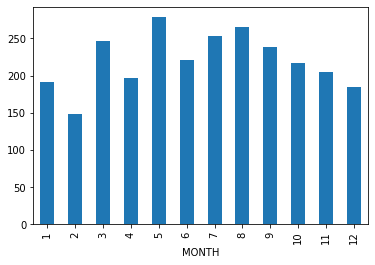

In [166]:
df_van[["YEAR","MONTH"]].groupby("MONTH").count().plot(kind="bar",legend=False)

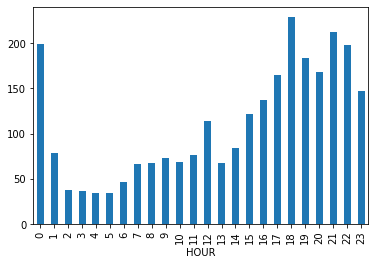

In [167]:
df_van[["HOUR","MONTH"]].groupby("HOUR").count().plot(kind="bar",legend=False)

In [197]:
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(df_van['latitude'], df_van['longitude']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        #popup=label,
        #color=rainbow[cluster-1],
        fill=False,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.2).add_to(map_clusters)
       
display(map_clusters)

In [34]:
CLIENT_ID = 'NMKQVCGCCXDYPH4IHUGWGRXBGGF1K2NNSC34R1BX3YZZF0RZ' # your Foursquare ID
CLIENT_SECRET = '03VTG0FIFQWRXLA3B5YMEBYEVTMKY4SXMTQ2HLLHJUELXSOP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [35]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results=""
        err=""
        for i in range(0,10):
            # make the GET request
            try:
                #print (name,lat,lng)
                results = requests.get(url).json()["response"]['groups'][0]['items']
                #print (results)
                break
            except Exception as e:
                print (name,lat,lng)
                err=e
                continue
            break
        
        if results == "" :
            raise err
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
df_van.index

RangeIndex(start=0, stop=2646, step=1)

In [37]:
df_van_venues=pd.read_pickle("van_theft_venues.pkl")

#extract vancouver avenues 
df_van_venues = getNearbyVenues(names=df_van.index,
                                   latitudes=df_van['latitude'],
                                   longitudes=df_van['longitude']
                                  )

In [38]:
df_van_venues.shape

(42965, 7)

In [39]:
df_van[["latitude","longitude","X"]].groupby(["latitude","longitude"]).count()

X
latitude  longitude     
49.203164 -123.127073  1
49.203339 -123.130109  1
49.204256 -123.134773  1
49.204445 -123.138989  1
49.204565 -123.131011  4
49.205000 -123.129231  1
49.205416 -123.140394  1
49.205653 -123.115475  1
49.205693 -123.123030  1
49.205790 -123.123124  1
49.205809 -123.127606  1
49.205881 -123.142938  1
49.205979 -123.040311  1
49.206000 -123.119045  1
49.206071 -123.048918  2
49.206096 -123.136168  1
49.206138 -123.042117  1
49.206216 -123.037028  1
49.206239 -123.133427  1
49.206266 -123.146884  1
49.206267 -123.061520  1
49.206455 -123.108044  1
49.206467 -123.136281  1
49.206476 -123.047696  1
49.206498 -123.137667  1
49.206576 -123.126379  1
49.206582 -123.114718  1
49.206709 -123.142216  1
49.206779 -123.125058  1
49.206827 -123.043411  1
...                   ..
49.290680 -123.056422  1
49.290695 -123.140588  1
49.290933 -123.143274  1
49.290993 -123.134619  1
49.291057 -123.055059  2
49.291112 -123.127610  1
49.291233 -123.141539  1
49.291271 -123.141569  1
49.291286 -123.139532  1
49.291381 -123.135231  2
49.291473 -123.129293  1
49.291550 -123.139759  2
49.291663 -123.135110  1
49.291825 -123.135925  1
49.292066 -123.138599  1
49.292157 -123.049741  1
49.292301 -123.143142  1
49.292337 -123.134262  2
49.292395 -123.148237  1
49.292437 -123.141062  1
49.292653 -123.139504  1
49.292672 -123.139444  1
49.293105 -123.138894  1
49.293136 -123.135955  1
49.293183 -123.136054  1
49.293388 -123.138427  1
49.293457 -123.136469  1
49.294037 -123.137292  1
49.297867 -123.130810  1
49.300823 -123.130246  1

[2392 rows x 1 columns]

In [40]:
np.unique(df_van[["latitude","longitude"]].values)
#df_van

array([-123.21530646, -123.21326208, -123.21234673, ...,   49.29403731,
         49.29786739,   49.3008234 ])

In [41]:
df_van_venues.to_pickle("van_theft_venues.pkl")

In [42]:
df_toronto_1718.shape

(8175, 8)

#extract Toronto avenues 1
df_tor_venues = getNearbyVenues(names=df_toronto_1718.index[0:4500],
                                   latitudes=df_toronto_1718['Lat'][0:4500],
                                   longitudes=df_toronto_1718['Long'][0:4500]
                                  )

df_tor_venues.to_pickle("tor_theft_venues1.pkl")


#extract Toronto avenues 2
df_tor_venues2 = getNearbyVenues(names=df_toronto_1718.index[3000:6000],
                                   latitudes=df_toronto_1718['Lat'][3000:6000],
                                   longitudes=df_toronto_1718['Long'][3000:6000]
                                  )
df_tor_venues2.to_pickle("tor_theft_venues2.pkl")

#extract Toronto avenues 3
df_tor_venues3 = getNearbyVenues(names=df_toronto_1718.index[4500:8176],
                                   latitudes=df_toronto_1718['Lat'][4500:8176],
                                   longitudes=df_toronto_1718['Long'][4500:8176]
                                  )
df_tor_venues3.to_pickle("tor_theft_venues3.pkl")

In [103]:


df_tor_venues=pd.read_pickle("tor_theft_venues1.pkl")
#df_tor_venues2.read_pickle("tor_theft_venues2.pkl")
df_tor_venues3=pd.read_pickle("tor_theft_venues3.pkl")

#df_tor_venues.append(df_tor_venues2)
df_tor_all=df_tor_venues.append(df_tor_venues3,ignore_index=True)

In [104]:
df_tor_all.shape

(66934, 7)

In [43]:
df_van_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42965 entries, 0 to 42964
Data columns (total 7 columns):
Neighborhood              42965 non-null int64
Neighborhood Latitude     42965 non-null float64
Neighborhood Longitude    42965 non-null float64
Venue                     42965 non-null object
Venue Latitude            42965 non-null float64
Venue Longitude           42965 non-null float64
Venue Category            42965 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


In [49]:
df_tor_venues.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [44]:
df_van_group=df_van_venues[["Venue Category","Venue"]].groupby("Venue Category").count()

# Top eleven venues to get your car lost in Vancouver

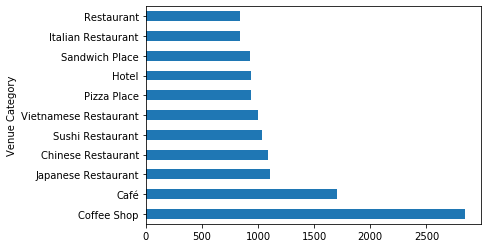

In [195]:
df_van_group.sort_values(by=["Venue"],ascending=False).head(11).plot(kind='barh',legend=False)

# Top eleven venues to get your car lost in Toronto 

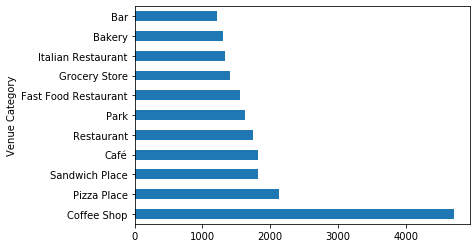

In [196]:
df_tor_group=df_tor_all[["Venue Category","Venue"]].groupby("Venue Category").count()
df_tor_group.sort_values(by=["Venue"],ascending=False).head(11).plot(kind='barh',legend=False)